In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/MC_Project/

/content/gdrive/My Drive/MC_Project


**Reading and Splitting Data into train and test**

In [ ]:
import pandas as pd

df = pd.read_csv('Final_Data.csv')
print(df.columns)

date_cgm = df['DateCGM'].tolist()
val_cgm = df['Value CGM'].tolist()
date_bolus = df['DateBolus'].tolist()
val_bolus = df['Value Bolus'].tolist()

date_cgm.reverse()
val_cgm.reverse()
date_bolus.reverse()
val_bolus.reverse()


Index(['DateCGM', 'Value CGM', 'DateBolus', 'Value Bolus'], dtype='object')


In [ ]:
from datetime import datetime

new_df = pd.DataFrame(columns=['Time', 'BG', 'Value Bolus', 'Date', 'Hour', 'Label'])
time_list = []
bg_list = []
bolus_val = []
date_list = []
hour_list = []
label_list =[]


for i in range(len(date_cgm)):
  date_time_obj = datetime.strptime(date_cgm[i],'%Y-%m-%d %H:%M:%S.%f')
  time_list.append(date_cgm[i])
  bg_list.append(val_cgm[i])
  bolus_val.append(val_bolus[i])
  date_list.append(date_time_obj.date())
  hour_list.append(str(date_time_obj.time())[:2])

  if val_bolus[i] > 1:
    label_list.append('Meal')
  else:
    label_list.append('No Meal')


new_df['Time'] = time_list
new_df['BG'] = bg_list
new_df['Value Bolus'] = bolus_val
new_df['Date'] = date_list
new_df['Hour'] = hour_list
new_df['Label'] = label_list

new_df.to_csv('Updated_final_data.csv', index=False)

#date_time_obj = datetime.strptime(date_cgm[0], '%Y-%m-%d %H:%M:%S.%f')
#print(date_cgm[0])
#print(date_time_obj.date())
#print(str(date_time_obj.time())[:2])

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('Updated_final_data.csv', index_col=False)

train_df, test_df = train_test_split(data, test_size=0.1, random_state=42, shuffle=False)

train_df.to_csv('CGM_train_data.csv', index=False)
test_df.to_csv('CGM_test_data.csv', index=False)

**Importing the necessary libraries**

In [ ]:
import datetime as dt
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras.models import Sequential, load_model 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statistics
import tensorflow as tf
import time

total_run_time_start_time = dt.datetime.now()
print('Start time: ' + str(dt.datetime.now()))

# Specify the GPU to use
gpu_number = str(0)

os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number


Start time: 2020-12-06 01:53:01.446999


**Reading train and test data**

In [ ]:
#To train the model
train_YN = 'Y'

input_train_file_name_prefix = 'cgm_detection'

plot_data = 'Y' 

# Set processed_train_file_name and processed_test_file_name
processed_train_file_name = 'CGM_train_data.csv'
processed_test_file_name = 'CGM_test_data.csv'

train_record_number = 1824

test_record_number = 396

# Number of epochs to run
num_epochs = 100
# Batch size
training_batch_size = 32
# Set initial loss value to 0.  
loss = 0

# Model file
model_file = input_train_file_name_prefix + '-' + str(num_epochs) + '-' + gpu_number + '.h5'


In [ ]:
train_df = pd.read_csv(str(processed_train_file_name), index_col=False)
test_df = pd.read_csv(str(processed_test_file_name), index_col=False)


**Grouping the data by Date and Hour**

In [ ]:
# Group CGM levels by Date and Hour in both dataframe 
train_means = train_df['BG'].groupby([train_df['Date'], train_df['Hour']]).mean()
print('Finished grouping by date for train')

test_means = test_df['BG'].groupby([test_df['Date'], test_df['Hour']]).mean()
print('Finished grouping by date for test')


Finished grouping by date for train
Finished grouping by date for test


**Plotting the data**

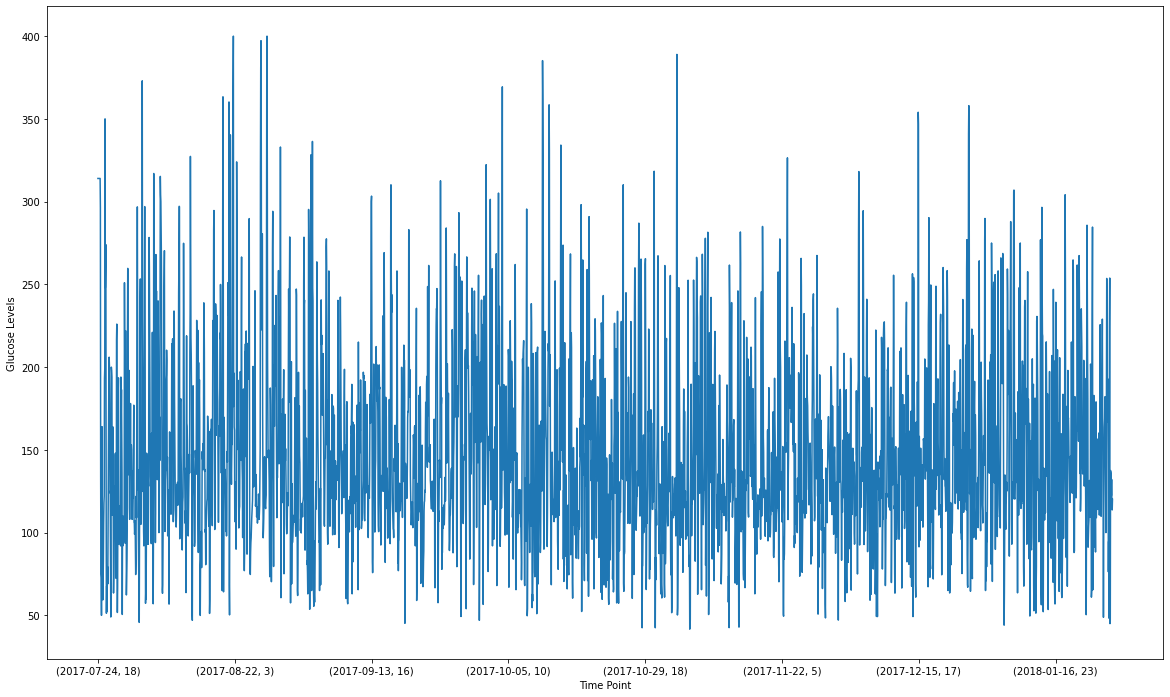

Beginning date for train_means
Date        Hour
2017-07-24  18      314.0
Name: BG, dtype: float64
Ending date for train_means
Date        Hour
2018-01-26  4       120.111111
Name: BG, dtype: float64


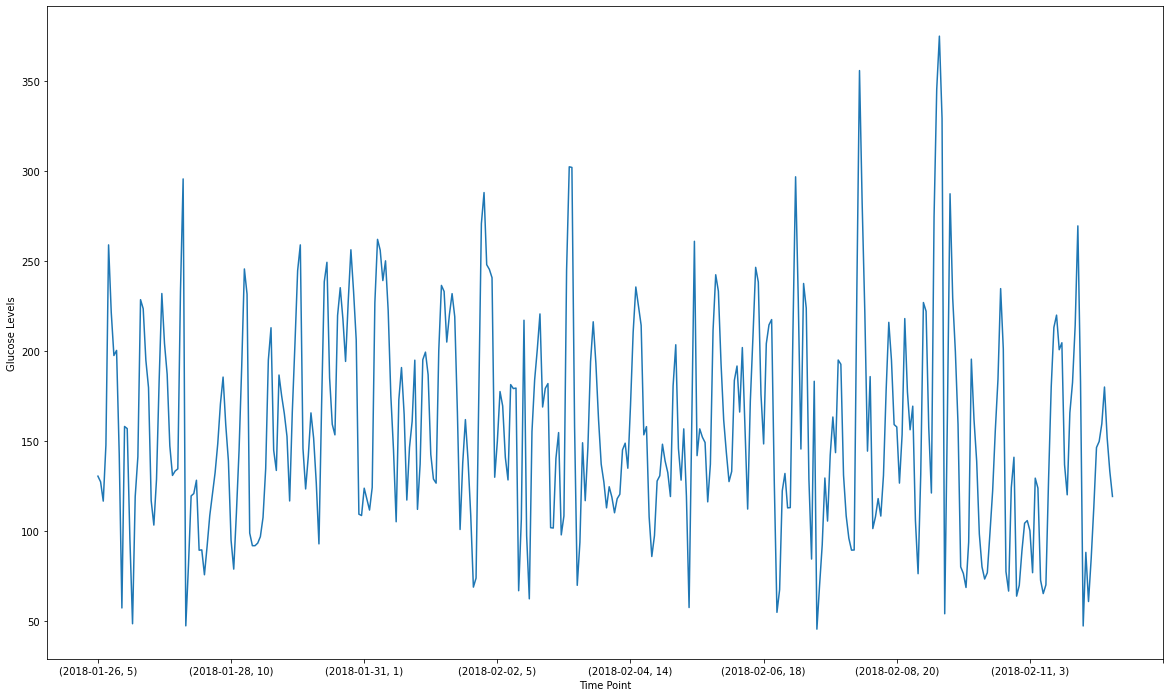

Beginning date for test_means
Date        Hour
2018-01-26  5       130.6
Name: BG, dtype: float64
Ending date for test_means
Date        Hour
2018-02-12  13      119.333333
Name: BG, dtype: float64


In [ ]:

# Plot means
if(plot_data == 'Y'):
  plt.figure(figsize=(20,12))
  train_means.plot()
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()

  print('Beginning date for train_means')
  print(train_means[[0]])
  print('Ending date for train_means')
  print(train_means[[len(train_means) - 1]])


if(plot_data == 'Y'):
  plt.figure(figsize=(20,12))
  test_means.plot()
  plt.xlabel('Time Point')  
  plt.ylabel('Glucose Levels')
  plt.show()  
    
  print('Beginning date for test_means')
  print(test_means[[0]])
  print('Ending date for test_means')
  print(test_means[[len(test_means) - 1]])


**Preparing the data for training**

In [ ]:

print('Begin adding elements to train_glucose_df')   
train_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, len(train_means)):
  temp_date = train_means.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  train_glucose_level = train_means[[i][0]]
  train_glucose_df.loc[len(train_glucose_df)] = [temp_date_hour, train_glucose_level]
print('Finished adding elements to train_glucose_df')  


print('Begin adding elements to test_glucose_df')  
test_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, len(test_means)):
  temp_date = test_means.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ':' + str(temp_date[1])
  test_glucose_level = test_means[[i][0]]
  test_glucose_df.loc[len(test_glucose_df)] = [temp_date_hour, test_glucose_level]
print('Finished adding elements to test_glucose_df')    


Begin adding elements to train_glucose_df
Finished adding elements to train_glucose_df
Begin adding elements to test_glucose_df
Finished adding elements to test_glucose_df


In [ ]:

# Scale training set
glucose_training_set = train_glucose_df.iloc[:,1:2].values
# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
glucose_training_set_scaled = scaler.fit_transform(glucose_training_set)


In [ ]:
features_set = []  
labels = []  

for i in range(60, train_record_number):  
    # Original
    # Updated (Get values from 0-59 to use as the value to predict 60)
    features_set.append(glucose_training_set_scaled[i-60:i, 0])
    labels.append(glucose_training_set_scaled[i, 0])

In [ ]:
# Reshape training set
features_set, labels = np.array(features_set), np.array(labels)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))



Begin Part 12 of 19 - Reshape training set


Finished Part 12 of 19 - Reshape training set.  Ready to move to next cell.


**Building the LSTM Model**

In [ ]:

# Build LSTM model
if train_YN == 'Y':
  model = Sequential() 

  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
  model.add(Dropout(0.2))  
  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))  
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))  
  model.add(Dropout(0.2)) 

  model.add(Dense(units = 1))  

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')


**Training and Saving the model**

In [ ]:
# Create model
if train_YN == 'Y':
    
  # Get start time for training
  training_start_time = dt.datetime.now()
    
  from keras.callbacks import EarlyStopping

  # Patient early stopping
  es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

  history = model.fit(features_set, labels, epochs = num_epochs, batch_size = training_batch_size, callbacks = [es])  

  loss = model.evaluate(features_set, labels, verbose=0)
  print('\nUnscaled Loss = ' + str(loss))

  # Save model
  model.save(str(model_file))

  # Get end time for training
  training_end_time = dt.datetime.now()

  # Calculate total training time
  training_total_time = str((training_end_time-training_start_time).total_seconds()) + ' seconds.'

  print('\n\nTotal training time ' + training_total_time)


Epoch 1/100
56/56 [==============================] - 6s 110ms/step - loss: 0.0386
Epoch 2/100
56/56 [==============================] - 7s 120ms/step - loss: 0.0292
Epoch 3/100
56/56 [==============================] - 7s 122ms/step - loss: 0.0283
Epoch 4/100
56/56 [==============================] - 7s 125ms/step - loss: 0.0286
Epoch 5/100
56/56 [==============================] - 8s 144ms/step - loss: 0.0288
Epoch 6/100
56/56 [==============================] - 7s 123ms/step - loss: 0.0283
Epoch 7/100
56/56 [==============================] - 7s 119ms/step - loss: 0.0281
Epoch 8/100
56/56 [==============================] - 7s 122ms/step - loss: 0.0280
Epoch 9/100
56/56 [==============================] - 7s 123ms/step - loss: 0.0278
Epoch 10/100
56/56 [==============================] - 7s 121ms/step - loss: 0.0278
Epoch 11/100
56/56 [==============================] - 7s 120ms/step - loss: 0.0276
Epoch 12/100
56/56 [==============================] - 7s 122ms/step - loss: 0.0277
Epoch 13/100


In [ ]:
glucose_total = pd.DataFrame(columns=['Glucose_Level'])

glucose_total = pd.concat((train_glucose_df['Glucose_Level'], test_glucose_df['Glucose_Level']), axis=0) 


**Preparing the Test Data**

In [ ]:
#Reshape test shape
test_inputs = glucose_total[len(train_glucose_df) - 60:].values 

test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)


In [ ]:
#Prep test set
test_features = []  
for i in range(60, test_record_number):  
    test_features.append(test_inputs[i-60:i, 0])
    
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))      


**Predictions on the Test Data**

In [ ]:
#Predictions
# Get start time for inference
inf_start_time = dt.datetime.now()

model = load_model(str(model_file))

predictions = model.predict(test_features)  

#Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

actual_predicted_difference_list = []

for i in range(0,len(predictions)):
    print('\nActual value for ' + str(test_glucose_df.loc[i,'Date_Hour']) + ' = ' 
          + str(test_glucose_df.loc[i,'Glucose_Level']))
    print('Predicted value = {0}'.format(predictions[i,0]))

    # Calculate mean square error
    actual_predicted_difference_list.append((predictions[i,0] - test_glucose_df.loc[i,'Glucose_Level']) ** 2)

mean_square = statistics.mean(actual_predicted_difference_list)
print('Mean square error = ' + str(mean_square))

# Get end time for inference
inf_end_time = dt.datetime.now()

# Calculate total inference time
inf_total_time = str((inf_end_time-inf_start_time).total_seconds()) + ' seconds.'

print('\n\nTotal inference time ' + inf_total_time)



Actual value for 2018-01-26:5 = 130.6
Predicted value = 132.66229248046875

Actual value for 2018-01-26:6 = 127.45454545454545
Predicted value = 142.70973205566406

Actual value for 2018-01-26:7 = 116.75
Predicted value = 134.0224609375

Actual value for 2018-01-26:8 = 147.9
Predicted value = 130.11585998535156

Actual value for 2018-01-26:9 = 259.0
Predicted value = 165.87850952148438

Actual value for 2018-01-26:10 = 221.57142857142858
Predicted value = 254.89903259277344

Actual value for 2018-01-26:11 = 197.58333333333334
Predicted value = 156.8645477294922

Actual value for 2018-01-26:12 = 200.41666666666666
Predicted value = 169.82797241210938

Actual value for 2018-01-26:13 = 142.75
Predicted value = 176.30601501464844

Actual value for 2018-01-26:14 = 57.42857142857143
Predicted value = 124.74888610839844

Actual value for 2018-01-26:15 = 158.1818181818182
Predicted value = 93.50370025634766

Actual value for 2018-01-26:16 = 157.0
Predicted value = 179.52142333984375

Actual v

**Plotting the predictions**



Plotting predictions


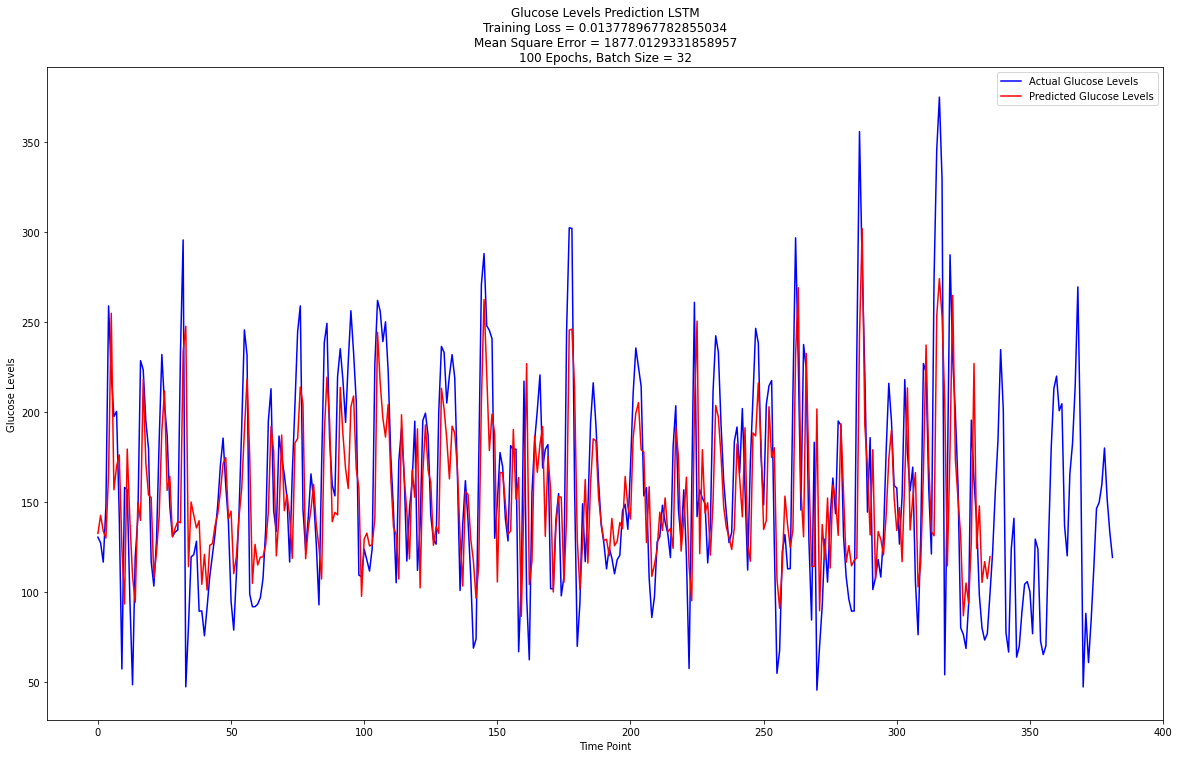

In [ ]:
#Plot predictions
actual = test_glucose_df['Glucose_Level'].values
actual = actual[0:len(test_glucose_df)]



plot_data = 'Y' 

print('\n\nPlotting predictions')
plt.figure(figsize=(20,12))  
plt.plot(actual, color='blue', label='Actual Glucose Levels')  
plt.plot(predictions , color='red', label='Predicted Glucose Levels')  
plt.title('Glucose Levels Prediction LSTM\n' + 'Training Loss = ' + str(loss) + '\nMean Square Error = ' + str(mean_square) + '\n' + str(num_epochs) + ' Epochs, ' + 'Batch Size = ' + str(training_batch_size))  
plt.xlabel('Time Point')  
plt.ylabel('Glucose Levels')  
plt.legend()  
plt.show() 



In [ ]:
bolus_val = test_df['Value Bolus'].tolist()

b_count = 0
count = 0
threshold = np.mean(train_df['BG'].tolist())*0.8
for i in range(len(predictions)):
  if bolus_val[i] > 1.0:
    b_count = b_count + 1

for i in range(len(predictions)):
  if abs(predictions[i] - actual[i]) > threshold:
    count = count + 1


print("Test Acc (%):", count/b_count*100)

Test Acc (%): 62.5
